## Exploratory Data Analysis (EDA) Notebook for Text Classification in SRE

### Import libraries

In [33]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from umap import UMAP
from tqdm.auto import tqdm

### Initial configuration

In [34]:
# Prioritizing efficiency with float16 and GPU by default
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Using torch.float16 for significant speed and memory efficiency on modern NVIDIA GPUs
DTYPE = torch.float16 if DEVICE == "cuda" else torch.float32

# Model and Dataset
EMBEDDING_MODEL_NAME = "all-MiniLM-L6-v2"
DATASET_NAME = "conll2003"
# Limit the dataset size to a fixed number for fast, reproducible demonstration
MAX_SAMPLES = 2000 
# Set a seed for UMAP reproducibility
SEED = 42

print(f"Using device: {DEVICE} with dtype: {DTYPE}")
print(f"Processing the first {MAX_SAMPLES} sentences from the '{DATASET_NAME}' dataset for speed.")


Using device: cpu with dtype: torch.float32
Processing the first 2000 sentences from the 'conll2003' dataset for speed.


### **Step 1**: Load Data with Hugging Face datasets

In [47]:
print("\nLoading and processing dataset...")
dataset = load_dataset(
    "csv",
    data_files="datasets/PROMISE_exp.csv",
    split="train",  # 'split="train"' loads the data directly, not as a DatasetDict
)
print(f"Features : {dataset.features}")
print(f"Total: {len(dataset)}")


Loading and processing dataset...
Features : {'project_id': Value('int64'), 'text': Value('string'), 'label': Value('string')}
Total: 969


### **Step 2**: Plot Label Frequency (Bar Chart)

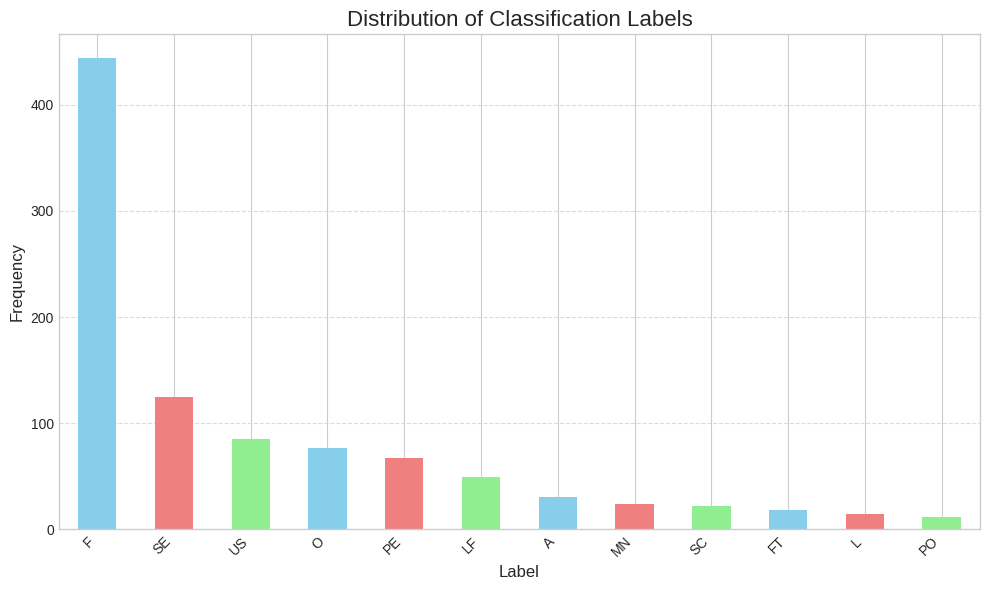


Label Counts:
 F     444
SE    125
US     85
O      77
PE     67
LF     49
A      31
MN     24
SC     22
FT     18
L      15
PO     12
Name: count, dtype: int64


In [36]:
# Convert the 'label' column to a Pandas Series for easy counting
label_counts = pd.Series(dataset['label']).value_counts()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Distribution of Classification Labels', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print actual counts
print("\nLabel Counts:\n", label_counts)

### **Step 3**: Semantic Visualization with UMAP and Embeddings

#### 3.1 Generate Embeddings

In [37]:
# 1. Load the model
print("Loading all-MiniLM-L6-v2 model...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Encode the text data
texts = dataset['text']
embeddings = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)

print(f"Embeddings generated with shape: {embeddings.shape}")

Loading all-MiniLM-L6-v2 model...


Batches: 100%|██████████| 31/31 [00:04<00:00,  7.24it/s]

Embeddings generated with shape: (969, 384)


#### 3.2 Reduce Dimensions with UMAP

In [38]:
# 1. Initialize UMAP reducer
print("Reducing dimensionality with UMAP...")
reducer = UMAP(
    n_components=2,          # Target 2 dimensions
    n_neighbors=10,          # Adjust based on dataset size; preserves local structure
    min_dist=0.1,            # Lower value creates tighter clusters
    metric='cosine',         # Standard for SBERT embeddings
    random_state=42
)

# 2. Fit and transform the embeddings
reduced_embeddings = reducer.fit_transform(embeddings)

# 3. Add UMAP coordinates and labels back to a DataFrame for plotting
df_plot = pd.DataFrame({
    'UMAP1': reduced_embeddings[:, 0],
    'UMAP2': reduced_embeddings[:, 1],
    'label': dataset['label']
})

/home/daniel/projects/git/organizations/data-science-adventure/huggingface-tutorial/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Reducing dimensionality with UMAP...


#### 3.3 Plot Semantic Clusters (Legend in Margin with All Labels)

This section creates the scatter plot and places the legend showing all colors and their corresponding classification labels in the margin of the plot.

/tmp/ipykernel_9933/3500064813.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set1', len(unique_labels))


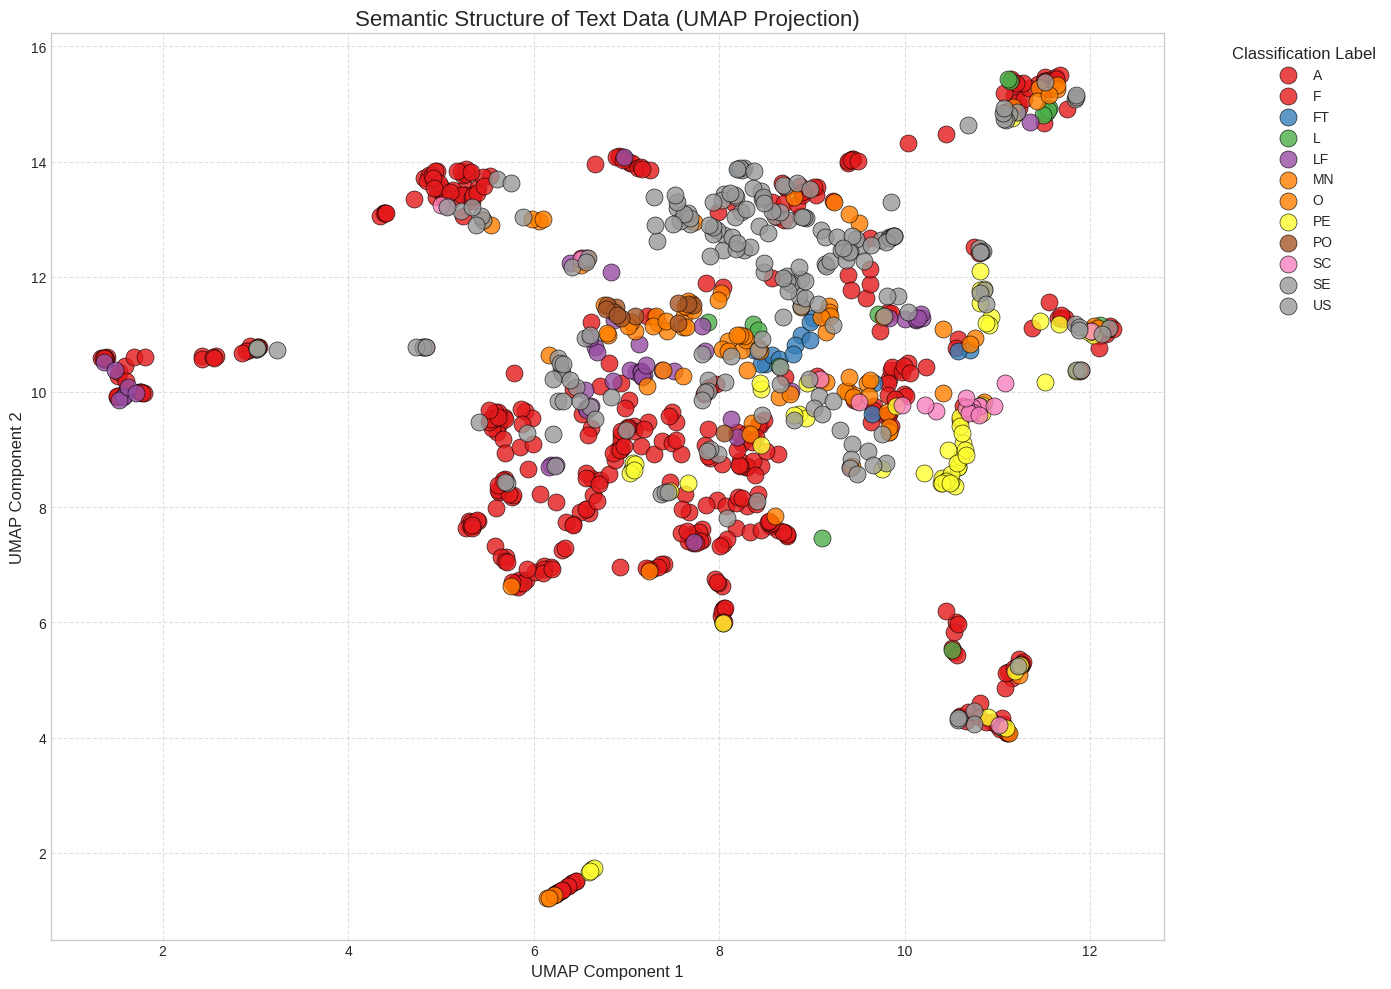


--- Interpretation ---
If points of the same color (label) group together, your classes are semantically well-separated, which is good for classification.
If different colors are heavily mixed, the semantic distinction between those classes is difficult, suggesting potential ambiguity in the labels or text.


In [42]:
plt.figure(figsize=(14, 10)) # Increased figure width for margin legend
plt.style.use('seaborn-v0_8-whitegrid')

# Get unique labels and the categorical colormap
unique_labels = df_plot['label'].astype('category').cat.categories.tolist()
cmap = plt.cm.get_cmap('Set1', len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]

# Create a mapping from label name to color code
label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}

# Plot each label group individually
for label_name in unique_labels:
    subset = df_plot[df_plot['label'] == label_name]
    plt.scatter(
        subset['UMAP1'],
        subset['UMAP2'],
        color=label_to_color[label_name],
        s=150,
        alpha=0.8,
        edgecolors='k',
        linewidth=0.5,
        label=label_name # The label keyword creates the legend entry
    )

# --- Legend in Margin with All Labels ---
# plt.legend() now uses the 'label' argument from the loop above
plt.legend(
    title="Classification Label",
    bbox_to_anchor=(1.05, 1), # Places the legend outside the plot area (the margin)
    loc='upper left',
    fontsize=10,
    title_fontsize=12
)

plt.title('Semantic Structure of Text Data (UMAP Projection)', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Interpretation Note ---
print("\n--- Interpretation ---")
print("If points of the same color (label) group together, your classes are semantically well-separated, which is good for classification.")
print("If different colors are heavily mixed, the semantic distinction between those classes is difficult, suggesting potential ambiguity in the labels or text.")

#### 3.4 Plot Semantic Clusters Functional vs No Functional requirements

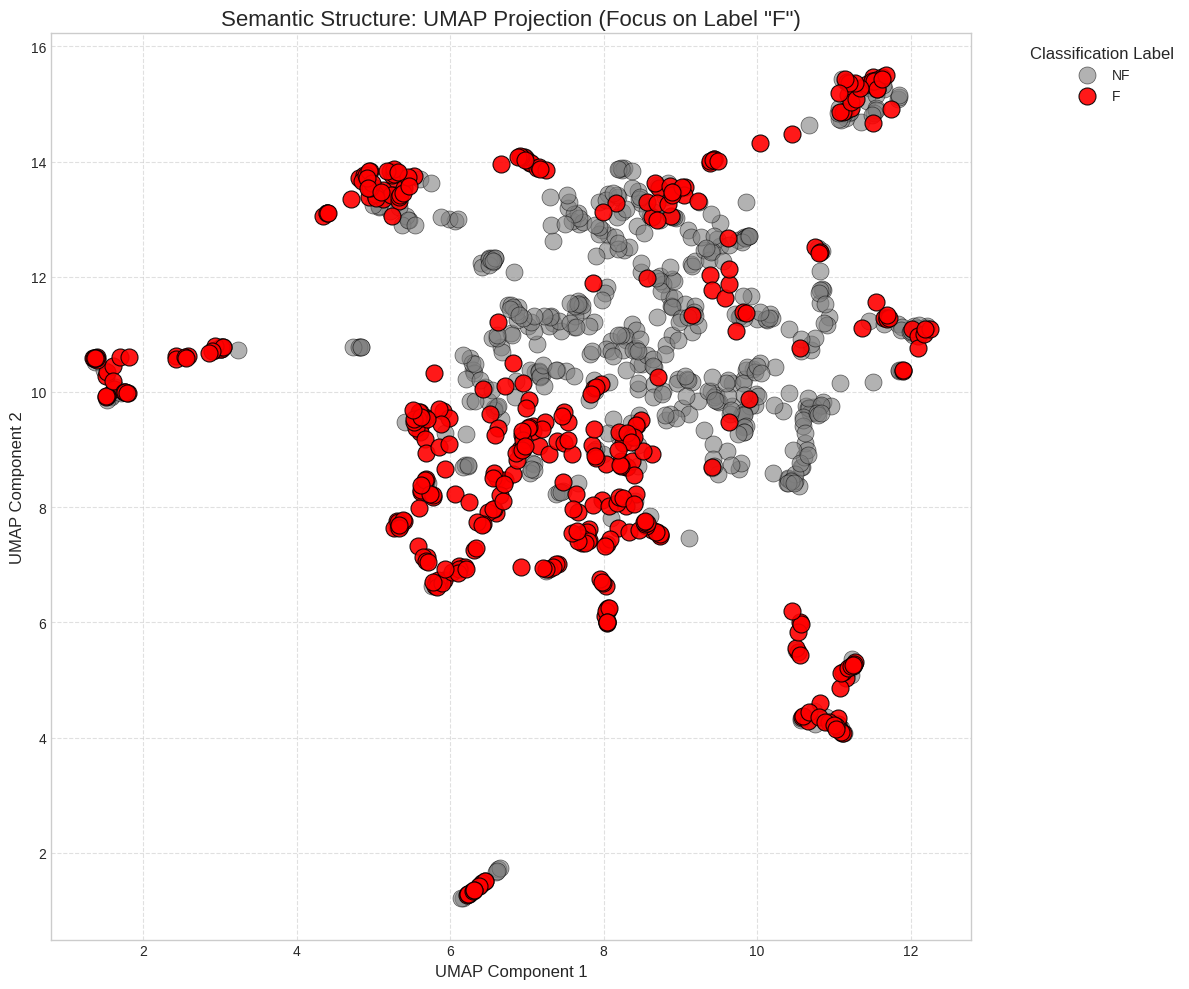


--- Interpretation ---
The red points ('F' label) are highlighted to visualize their semantic position relative to all other gray points (other labels).
If red points form a tight, distinct cluster, the 'F' class is semantically clear.


In [44]:
plt.figure(figsize=(12, 10))
plt.style.use('seaborn-v0_8-whitegrid')

# --- NEW: Assign Conditional Color ---
df_plot['plot_color'] = np.where(df_plot['label'] == 'F', 'red', 'gray')

# --- Plotting Individual Groups with Specific Colors ---
# Create groups for plotting: 'F' and 'Other'
f_subset = df_plot[df_plot['label'] == 'F']
other_subset = df_plot[df_plot['label'] != 'F']

# Plot 'Other' group (Gray)
plt.scatter(
    other_subset['UMAP1'],
    other_subset['UMAP2'],
    color='gray',
    s=150,
    alpha=0.6,
    edgecolors='k',
    linewidth=0.5,
    label='NF'
)

# Plot 'F' group (Red) on top
plt.scatter(
    f_subset['UMAP1'],
    f_subset['UMAP2'],
    color='red',
    s=150,
    alpha=0.9,
    edgecolors='k',
    linewidth=0.8,
    label='F'
)

# --- Legend in Margin ---
plt.legend(
    title="Classification Label",
    bbox_to_anchor=(1.05, 1), # Places the legend outside the plot area
    loc='upper left',
    fontsize=10,
    title_fontsize=12
)

plt.title('Semantic Structure: UMAP Projection (Focus on Label "F")', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Interpretation Note ---
print("\n--- Interpretation ---")
print("The red points ('F' label) are highlighted to visualize their semantic position relative to all other gray points (other labels).")
print("If red points form a tight, distinct cluster, the 'F' class is semantically clear.")